# Setup

In [1]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from data_loading import get_gtzan_dataframe, get_fma_dataframe, prepare_dataloader_based_on_df
from model import CNN
from metric_calc import reset_metrics, update_metrics, compute_metrics, create_metric_dictionary
from metric_display import draw_metrics, print_metric_dictionary
from metric_sets import create_basic_multiclass_metrics, create_full_multiclass_metrics, create_basic_binary_metrics, create_full_binary_metrics
from reports import experiment_info, write_results_report_to_new_file

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Variables

In [4]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [5]:
report_output_root_dir = Path('../../output')

# report_output_dirs = {'gtzan_multiclass': report_output_root_dir / 'gtzan_multiclass',
#                       'fma_small_multiclass': report_output_root_dir / 'fma_small_multiclass',
#                       'fma_medium_multiclass': report_output_root_dir / 'fma_medium_multiclass',
                      
#                       'gtzan_binary': report_output_root_dir / 'gtzan_binary',
#                       'fma_small_binary': report_output_root_dir / 'fma_small_binary',
#                       'fma_medium_binary': report_output_root_dir / 'fma_medium_binary'}

report_output_dirs = { 'binary_balanced': report_output_root_dir / 'binary_balanced',
                       'binary_unbalanced': report_output_root_dir / 'binary_unbalanced',
                       
                       'multiclass_balanced': report_output_root_dir / 'multiclass_balanced',          
                       'multiclass_unbalanced': report_output_root_dir / 'multiclass_unbalanced',
                       
                       'multilabel_balanced': report_output_root_dir / 'multilabel_balanced',
                       'multilabel_unbalanced': report_output_root_dir / 'multilabel_unbalanced'}

In [6]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [7]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)
BATCH_SIZE = 32
CHANNELS = 3

# Clean output directories

Contents of subfolders are intentionally NOT cleaned. This way, interesting results can be persisted if they have a dedicated subfolder.

In [8]:
for dir_path in report_output_dirs.values():
    for file_path in dir_path.glob('*.txt'):
        file_path.unlink()
    for file_path in dir_path.glob('*.png'):
        file_path.unlink()

# Create GTZAN DataLoaders

In [8]:
# With val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(True, gtzan_df_path, gtzan_image_dir)

gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

In [ ]:
# Without val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(False, gtzan_df_path, gtzan_image_dir)

gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

# Create FMA-small DataLoaders

In [22]:
# With val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True,
                                                                            with_val=True,
                                                                            fma_df_path=fma_df_path,
                                                                            fma_image_dir=fma_medium_image_dir)

fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_small_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

In [8]:
# Without val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True,
                                                          with_val=False,
                                                          fma_df_path=fma_df_path,
                                                          fma_image_dir=fma_medium_image_dir)

fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

# Create FMA-medium DataLoaders

In [ ]:
# With val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False,
                                                                               with_val=True,
                                                                               fma_df_path=fma_df_path,
                                                                               fma_image_dir=fma_medium_image_dir)

fma_medium_train_dl = prepare_dataloader_based_on_df(fma_medium_train_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_medium_val_dl = prepare_dataloader_based_on_df(fma_medium_val_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_medium_test_dl = prepare_dataloader_based_on_df(fma_medium_test_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

In [ ]:
# Without val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False,
                                                            with_val=False,
                                                            fma_df_path=fma_df_path,
                                                            fma_image_dir=fma_medium_image_dir)

fma_medium_train_dl = prepare_dataloader_based_on_df(fma_medium_train_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_medium_test_dl = prepare_dataloader_based_on_df(fma_medium_test_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

# Training/Test loops

In [9]:
#==================================================================================  
# Test loop
#==================================================================================  
def test_loop(model, metrics, class_names, test_dl):
    is_binary_classification = len(class_names) == 2
    reset_metrics(metrics)
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not calculate gradients
        for inputs, labels in test_dl: # get batch (batch_size specified during DataLoader creation)
            outputs = model(inputs)                       # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
            
            update_metrics(metrics, outputs, labels)      # update metrics after batch
    
    computed_metrics = compute_metrics(metrics) # calculate metrics after whole epoch
    print_metric_dictionary(create_metric_dictionary(computed_metrics, class_names))
    draw_metrics(computed_metrics, class_names)
    reset_metrics(metrics)
    return computed_metrics

In [10]:
# Training and optional validation at end of epoch
def training_loop(model, epochs, basic_metrics, class_names, train_dl, val_dl = None, full_metrics = None):
    is_binary_classification = len(class_names) == 2
    
    # PREDICTIONS: logits, LABELS: numerical
    loss_function = nn.BCEWithLogitsLoss() if is_binary_classification else nn.CrossEntropyLoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    reset_metrics(basic_metrics)
    
    #==================================================================================  
    # Training loop
    #==================================================================================  
    for epoch in range(epochs):
        model.train() # training mode
        running_loss = 0.0
        for inputs, labels in train_dl: # get batch (batch_size specified during DataLoader creation)
            optimizer.zero_grad()           # zero the parameter gradients
            outputs = model(inputs)         # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
                     
            loss = loss_function(outputs, labels) # calculate loss (logits, numerical labels)
            update_metrics(basic_metrics, outputs, labels)
            
            loss.backward()                 # backward pass
            optimizer.step()                # optimize weights
            running_loss += loss.item()     # accumulate loss
            
        # Calculate, display and reset TRAINING loop metrics
        print("TRAINING=======") 
        print(f"[EPOCH {epoch+1}], LOSS: {running_loss/len(train_dl)}")   
        computed_basic_metrics = compute_metrics(basic_metrics)
        print_metric_dictionary(create_metric_dictionary(computed_basic_metrics, class_names))
        reset_metrics(basic_metrics)
        
        #==================================================================================  
        # VALIDATION at end of epoch if val_dl is provided
        #================================================================================== 
        if val_dl is not None:
            print("VALIDATION=======") 
            
            # Calculate and display FULL METRIC SET if its the LAST VALIDATION loop
            # and the full metric set was provided
            if epoch == epochs - 1 and full_metrics is not None:
                test_loop(model, full_metrics, class_names, val_dl)
            else:
                test_loop(model, basic_metrics, class_names, val_dl)
        
        print("=====================================")

# Create and train GTZAN model

In [11]:
gtzan_multi_model_name = "model8"
gtzan_multi_test_set = "test"

In [12]:
gtzan_multi_exp_info = experiment_info(gtzan_multi_model_name,
                                       "GTZAN",
                                       "multi",
                                       gtzan_multi_test_set,
                                       gtzan_classes)

In [13]:
GTZAN_MULTI_EPOCHS = 1
GTZAN_MULTI_TOTAL_EPOCHS = 0

In [14]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(gtzan_classes)).to(device) #! model to device

In [15]:
gtzan_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(gtzan_classes), device=device)
gtzan_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(gtzan_classes), device=device)

TRAINING=======
[EPOCH 1], LOSS: 3.1389775609970094
macro_accuracy: 0.8497
macro_recall: 0.2488
macro_precision: 0.2411
macro_f1: 0.2429
precision_per_class:
	Blues: 0.1525, Classical: 0.3820, Country: 0.2121, Disco: 0.1594, Hip-Hop: 0.2360, Jazz: 0.1385, Metal: 0.5176, Pop: 0.1967, Reggae: 0.2805, Rock: 0.1351, 
recall_per_class:
	Blues: 0.1125, Classical: 0.4250, Country: 0.1750, Disco: 0.1375, Hip-Hop: 0.2625, Jazz: 0.1125, Metal: 0.5500, Pop: 0.3000, Reggae: 0.2875, Rock: 0.1250, 
VALIDATION=======


        [7]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


macro_accuracy: 0.8327
macro_recall: 0.1600
macro_precision: 0.2762
macro_f1: 0.1203
precision_per_class:
	Blues: 0.2500, Classical: 0.0000, Country: 1.0000, Disco: 0.0930, Hip-Hop: 0.2000, Jazz: 0.0000, Metal: 1.0000, Pop: 0.0000, Reggae: 0.0000, Rock: 0.2188, 
recall_per_class:
	Blues: 0.2000, Classical: 0.0000, Country: 0.1000, Disco: 0.4000, Hip-Hop: 0.1000, Jazz: 0.0000, Metal: 0.1000, Pop: 0.0000, Reggae: 0.0000, Rock: 0.7000, 


TRAINING=======
[EPOCH 2], LOSS: 1.8888761520385742
macro_accuracy: 0.8743
macro_recall: 0.3713
macro_precision: 0.3759
macro_f1: 0.3707
precision_per_class:
	Blues: 0.2903, Classical: 0.6061, Country: 0.2527, Disco: 0.2885, Hip-Hop: 0.3434, Jazz: 0.2698, Metal: 0.7500, Pop: 0.4533, Reggae: 0.2708, Rock: 0.2344, 
recall_per_class:
	Blues: 0.2250, Classical: 0.5000, Country: 0.2875, Disco: 0.3750, Hip-Hop: 0.4250, Jazz: 0.2125, Metal: 0.7500, Pop: 0.4250, Reggae: 0.3250, Rock: 0.1875, 
VALIDATION=======
macro_accuracy: 0.8694
macro_recall: 0.3433
macro_precision: 0.5160
macro_f1: 0.3071
precision_per_class:
	Blues: 0.2143, Classical: 1.0000, Country: 0.2105, Disco: 0.5000, Hip-Hop: 1.0000, Jazz: 0.0000, Metal: 0.4211, Pop: 0.5833, Reggae: 1.0000, Rock: 0.2308, 
recall_per_class:
	Blues: 0.6000, Classical: 0.1000, Country: 0.4000, Disco: 0.1000, Hip-Hop: 0.1000, Jazz: 0.0000, Metal: 0.8000, Pop: 0.7000, Reggae: 0.3333, Rock: 0.3000, 
TRAINING=======
[EPOCH 3], LOSS: 1.777497272491455
mac

c:\VisualStudioRepositories\MUSIC_DATA\music_genre_classification\src\experiment\custom_qualitative_metrics.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


macro_accuracy: 0.8878
micro_accuracy: 0.8878
accuracy_per_class:
	Blues: 0.9286, Classical: 0.9388, Country: 0.8980, Disco: 0.8980, Hip-Hop: 0.9286, Jazz: 0.8776, Metal: 0.9388, Pop: 0.9082, Reggae: 0.7755, Rock: 0.7857, 
macro_f1: 0.4152
micro_f1: 0.4388
f1_per_class:
	Blues: 0.4615, Classical: 0.6250, Country: 0.1667, Disco: 0.0000, Hip-Hop: 0.6316, Jazz: 0.2500, Metal: 0.6250, Pop: 0.5714, Reggae: 0.4211, Rock: 0.4000, 
macro_precision: 0.5220
micro_precision: 0.4388
precision_per_class:
	Blues: 1.0000, Classical: 0.8333, Country: 0.5000, Disco: 0.0000, Hip-Hop: 0.6667, Jazz: 0.2857, Metal: 0.8333, Pop: 0.5455, Reggae: 0.2759, Rock: 0.2800, 
macro_recall: 0.4411
micro_recall: 0.4388
recall_per_class:
	Blues: 0.3000, Classical: 0.5000, Country: 0.1000, Disco: 0.0000, Hip-Hop: 0.6000, Jazz: 0.2222, Metal: 0.5000, Pop: 0.6000, Reggae: 0.8889, Rock: 0.7000, 
Cohen's Kappa: 0.3776
MCC: 0.3982
MSE: 0.0699
LogLoss: 1.5705
AUNu: 0.8806
AUNp: 0.8806
AU1u: 0.8810
AU1p: 0.8808
ROC-AUC_per_cla

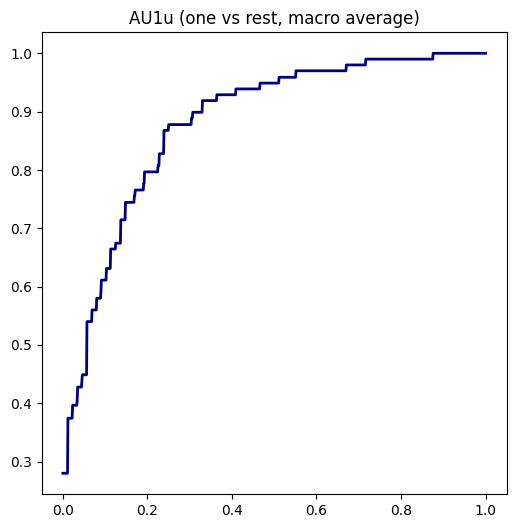

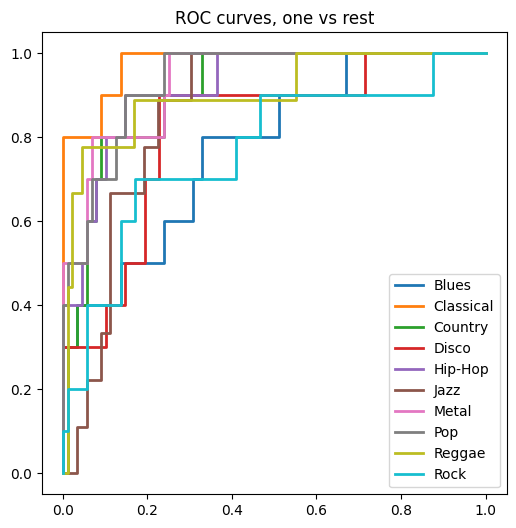

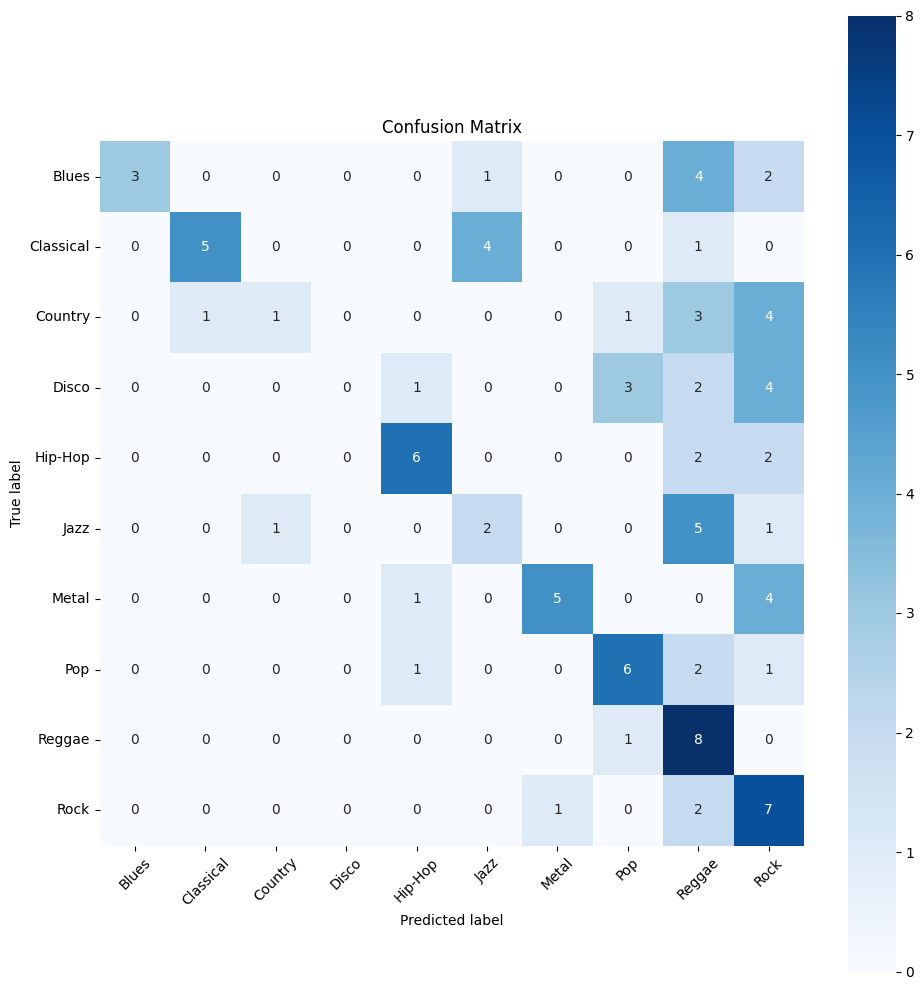

In [16]:
training_loop(model=model_gtzan,
              epochs=GTZAN_MULTI_EPOCHS,
              basic_metrics=gtzan_basic_multiclass_metrics,
              class_names=gtzan_classes,
              train_dl=gtzan_train_dl,
              val_dl=gtzan_val_dl,
              full_metrics=gtzan_full_multiclass_metrics)

GTZAN_MULTI_TOTAL_EPOCHS += GTZAN_MULTI_EPOCHS

c:\VisualStudioRepositories\MUSIC_DATA\music_genre_classification\src\experiment\custom_qualitative_metrics.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


macro_accuracy: 0.8840
micro_accuracy: 0.8840
accuracy_per_class:
	Blues: 0.9200, Classical: 0.9500, Country: 0.8800, Disco: 0.8800, Hip-Hop: 0.8700, Jazz: 0.8900, Metal: 0.9600, Pop: 0.9200, Reggae: 0.7800, Rock: 0.7900, 
macro_f1: 0.4209
micro_f1: 0.4200
f1_per_class:
	Blues: 0.3333, Classical: 0.6667, Country: 0.2500, Disco: 0.1429, Hip-Hop: 0.4348, Jazz: 0.3529, Metal: 0.8000, Pop: 0.6000, Reggae: 0.3529, Rock: 0.2759, 
macro_precision: 0.5257
micro_precision: 0.4200
precision_per_class:
	Blues: 1.0000, Classical: 1.0000, Country: 0.3333, Disco: 0.2500, Hip-Hop: 0.3846, Jazz: 0.4286, Metal: 0.8000, Pop: 0.6000, Reggae: 0.2500, Rock: 0.2105, 
macro_recall: 0.4200
micro_recall: 0.4200
recall_per_class:
	Blues: 0.2000, Classical: 0.5000, Country: 0.2000, Disco: 0.1000, Hip-Hop: 0.5000, Jazz: 0.3000, Metal: 0.8000, Pop: 0.6000, Reggae: 0.6000, Rock: 0.4000, 
Cohen's Kappa: 0.3556
MCC: 0.3645
MSE: 0.0753
LogLoss: 1.6965
AUNu: 0.8424
AUNp: 0.8424
AU1u: 0.8424
AU1p: 0.8424
ROC-AUC_per_cla

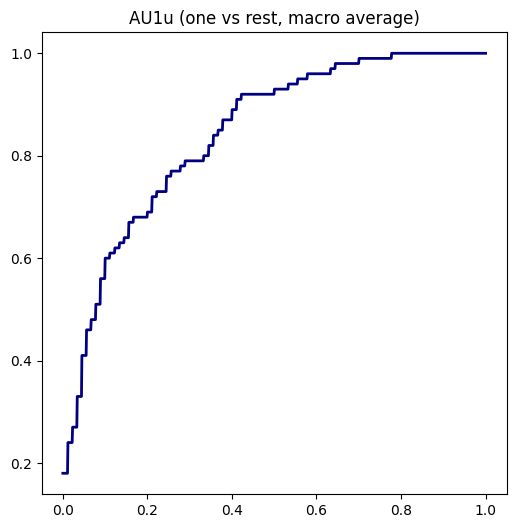

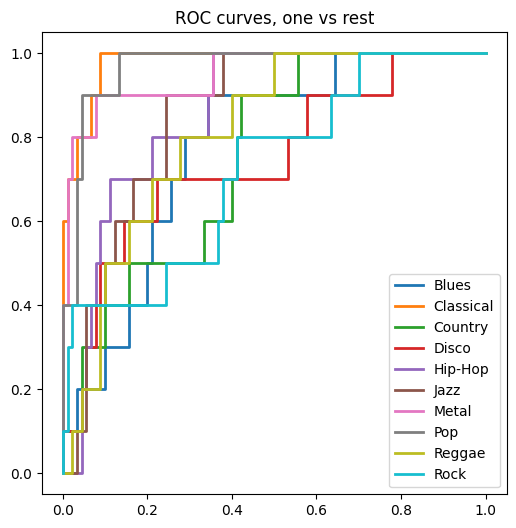

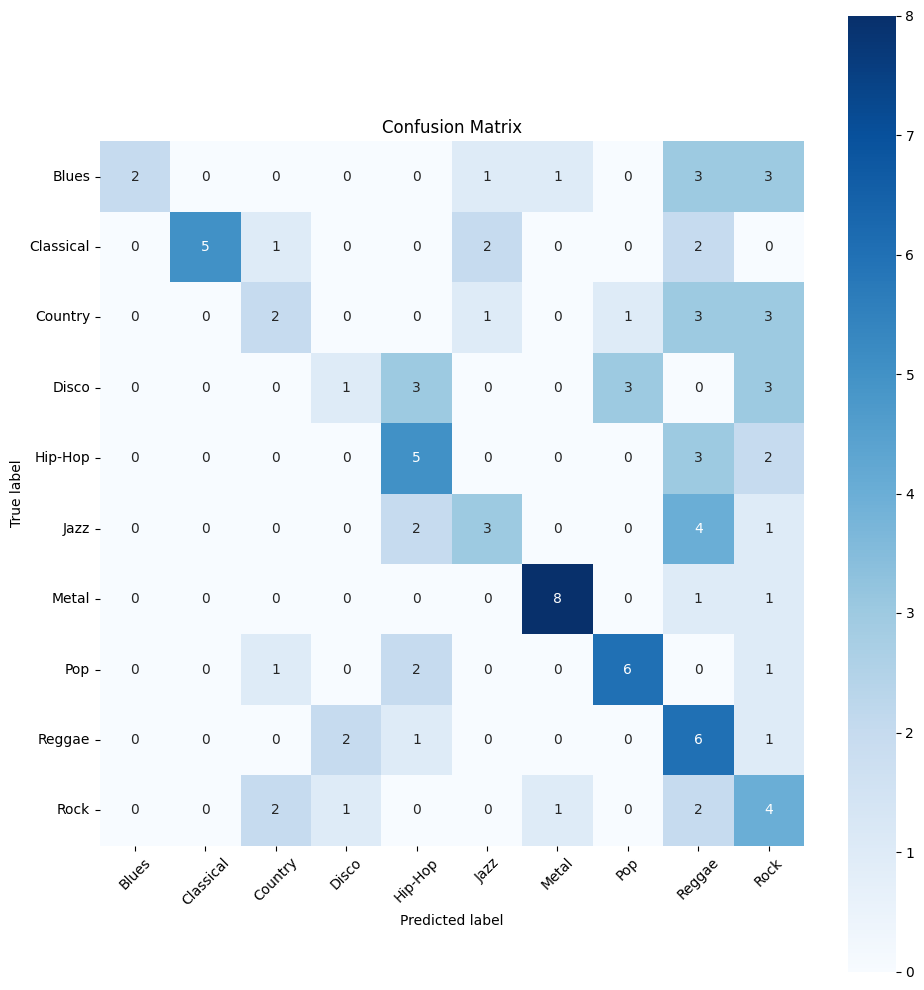

In [17]:
results = test_loop(model_gtzan, gtzan_full_multiclass_metrics, gtzan_classes, gtzan_test_dl)

Different micro and macro when a class has, for example, no TP in precision TP/(TP+FP)

Macro DOES count the 0, micro does not

Example:

(0.75+0.6+0.5714+0+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/10 = 0.53297

(0.75+0.6+0.5714+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/9 = 0.592

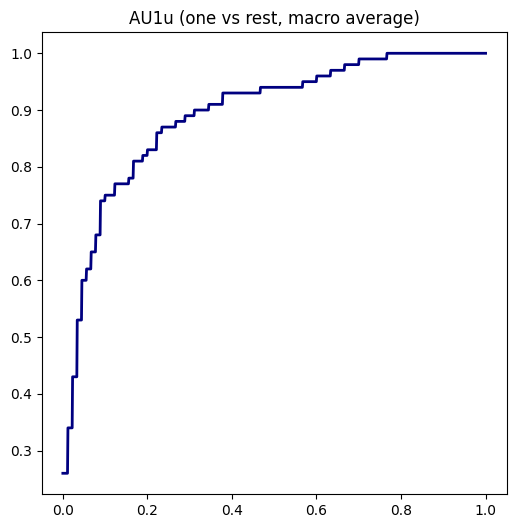

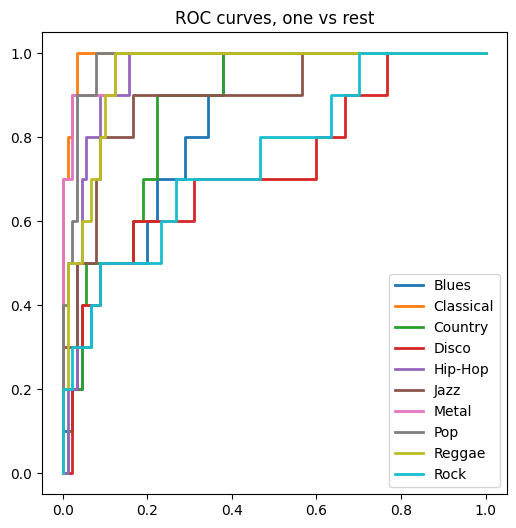

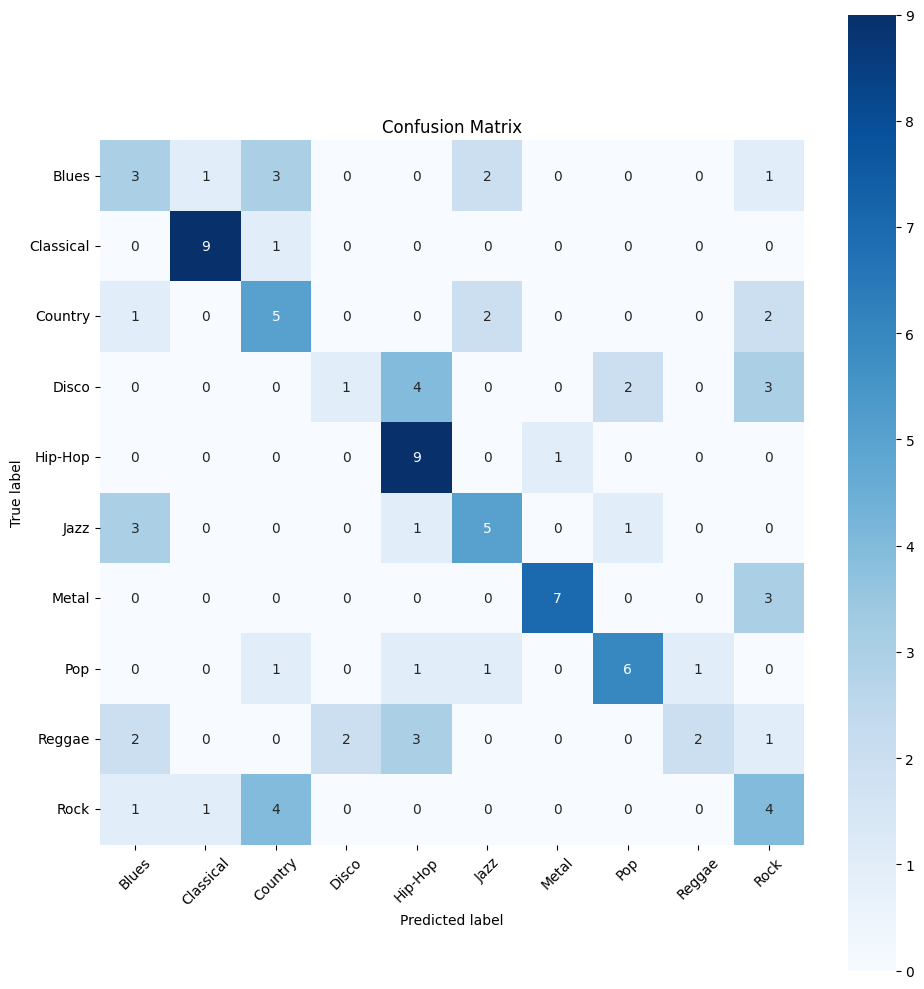

In [21]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['gtzan_multi'],
                                 experiment_info=gtzan_multi_exp_info,
                                 epochs=GTZAN_MULTI_TOTAL_EPOCHS,
                                 results=results)

# Create and train FMA-small model

In [43]:
fma_small_multiclass_model_name = "cnn"
fma_small_multiclass_test_set = "test"
fma_small_multiclass_index = 4
fma_small_dataset_name = "fma_small"

In [44]:
fma_small_output_dir = fma_small_multiclass_model_name + "_" + fma_small_dataset_name + "_" + str(fma_small_multiclass_index)

In [45]:
fma_small_multi_exp_info = experiment_info(fma_small_multiclass_model_name,
                                            fma_small_dataset_name,
                                            "multiclass",
                                            fma_small_multiclass_test_set,
                                            fma_small_multiclass_index,
                                            fma_small_top_classes)

In [23]:
FMA_SMALL_MULTI_EPOCHS = 5
FMA_SMALL_MULTI_TOTAL_EPOCHS = 0

In [24]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_small_top_classes)).to(device)

In [25]:
fma_small_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_small_top_classes), device=device)
fma_small_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_small_top_classes), device=device)

In [26]:
training_loop(model=model_fma_small,
              epochs=FMA_SMALL_MULTI_EPOCHS,
              basic_metrics=fma_small_basic_multiclass_metrics,
              class_names=fma_small_top_classes,
              train_dl=fma_small_train_dl,
              #val_dl=fma_small_val_dl,
              full_metrics=fma_small_full_multiclass_metrics)

FMA_SMALL_MULTI_TOTAL_EPOCHS += FMA_SMALL_MULTI_EPOCHS

TRAINING=======
[EPOCH 1], LOSS: 2.0697061157226564
micro_precision: 0.3012
macro_precision: 0.2943
macro_recall: 0.3013
macro_f1: 0.2959
MSE: 0.1057
precision_per_class:
	Electronic: 0.2660, Experimental: 0.2644, Folk: 0.3093, Hip-Hop: 0.3211, Instrumental: 0.3894, International: 0.2482, Pop: 0.1606, Rock: 0.3952, 
recall_per_class:
	Electronic: 0.2553, Experimental: 0.2178, Folk: 0.3425, Hip-Hop: 0.3965, Instrumental: 0.3475, International: 0.2550, Pop: 0.1213, Rock: 0.4743, 
TRAINING=======
[EPOCH 2], LOSS: 1.6928293776512147
micro_precision: 0.3910
macro_precision: 0.3807
macro_recall: 0.3910
macro_f1: 0.3841
MSE: 0.0939
precision_per_class:
	Electronic: 0.3664, Experimental: 0.2948, Folk: 0.4625, Hip-Hop: 0.4256, Instrumental: 0.4237, International: 0.3412, Pop: 0.2367, Rock: 0.4949, 
recall_per_class:
	Electronic: 0.3517, Experimental: 0.2390, Folk: 0.5325, Hip-Hop: 0.4956, Instrumental: 0.4200, International: 0.3625, Pop: 0.1775, Rock: 0.5494, 
TRAINING=======
[EPOCH 3], LOSS: 1

c:\VisualStudioRepositories\MUSIC_DATA\music_genre_classification\src\experiment\qualitative_metrics\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


macro_accuracy: 0.8414
micro_accuracy: 0.8414
accuracy_per_class:
	Electronic: 0.8469, Experimental: 0.8562, Folk: 0.8562, Hip-Hop: 0.8913, Instrumental: 0.7031, International: 0.8806, Pop: 0.8006, Rock: 0.8963, 
macro_precision: 0.4384
micro_precision: 0.3656
precision_per_class:
	Electronic: 0.4009, Experimental: 0.3729, Folk: 0.3986, Hip-Hop: 0.5580, Instrumental: 0.2658, International: 0.6216, Pop: 0.1713, Rock: 0.7179, 
macro_recall: 0.3656
micro_recall: 0.3656
recall_per_class:
	Electronic: 0.4550, Experimental: 0.2200, Folk: 0.2950, Hip-Hop: 0.6250, Instrumental: 0.7800, International: 0.1150, Pop: 0.1550, Rock: 0.2800, 
macro_f1: 0.3485
micro_f1: 0.3656
f1_per_class:
	Electronic: 0.4262, Experimental: 0.2767, Folk: 0.3391, Hip-Hop: 0.5896, Instrumental: 0.3964, International: 0.1941, Pop: 0.1627, Rock: 0.4029, 
Kappa: 0.2750
MSE: 0.0961
LogLoss: 1.7094
AUNU: 0.8005
micro_ROC-AUC: 0.7856
AUNP: 0.8005
AU1U: 0.8005
AU1P: 0.8005
ROC-AUC_per_class_vs_rest:
	Electronic: 0.8000, Exper

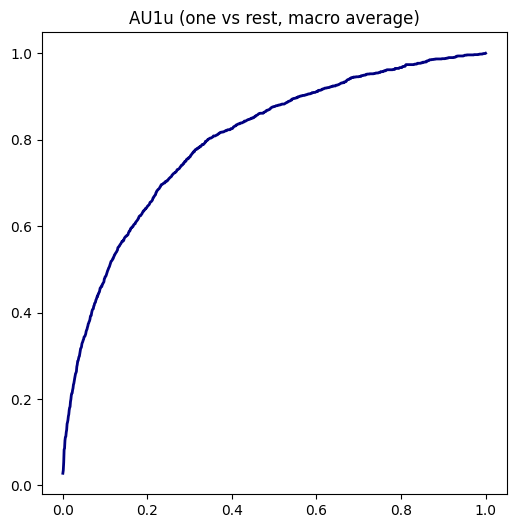

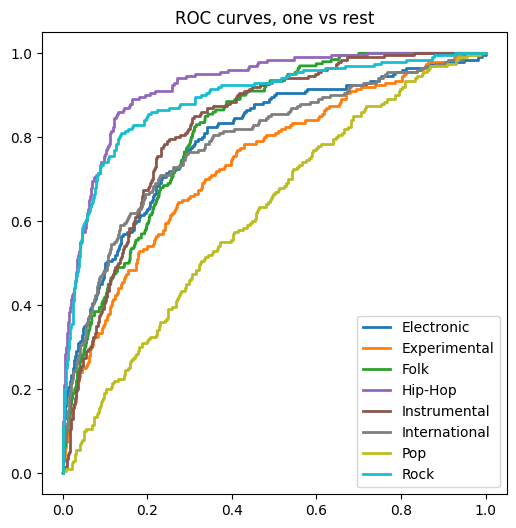

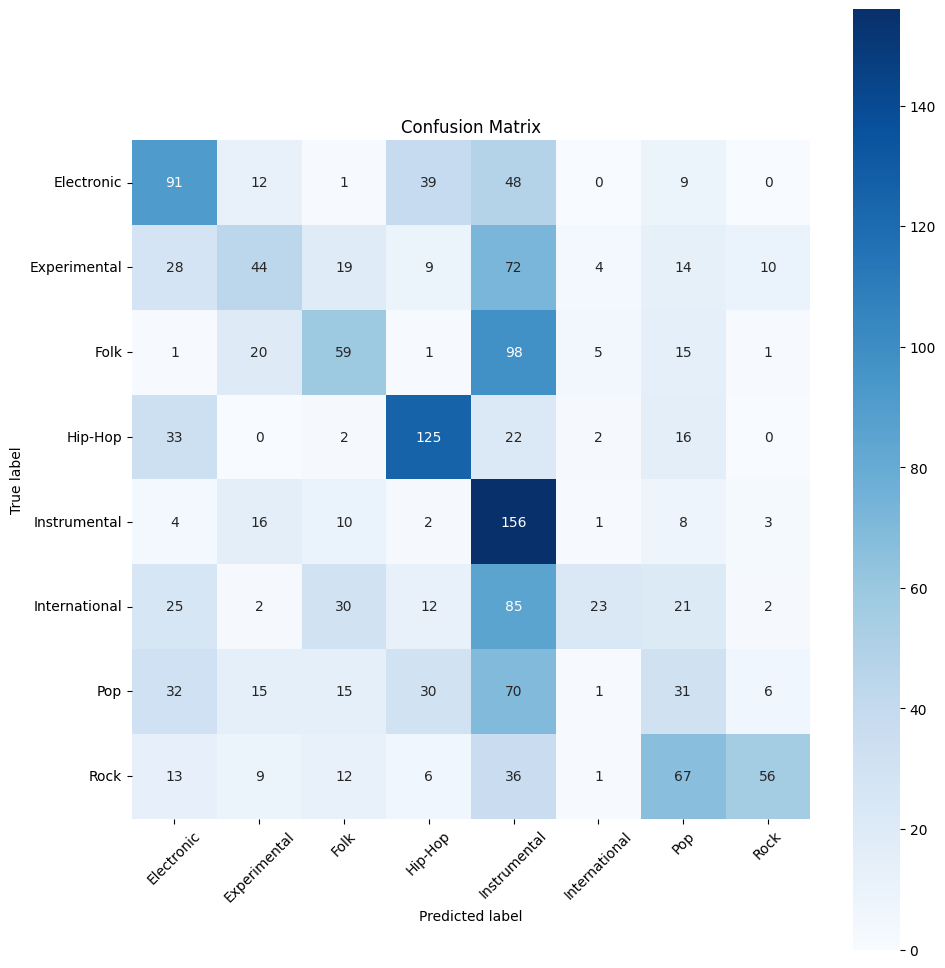

In [46]:
results_fma_small = test_loop(model_fma_small, fma_small_full_multiclass_metrics, fma_small_top_classes, fma_small_test_dl)

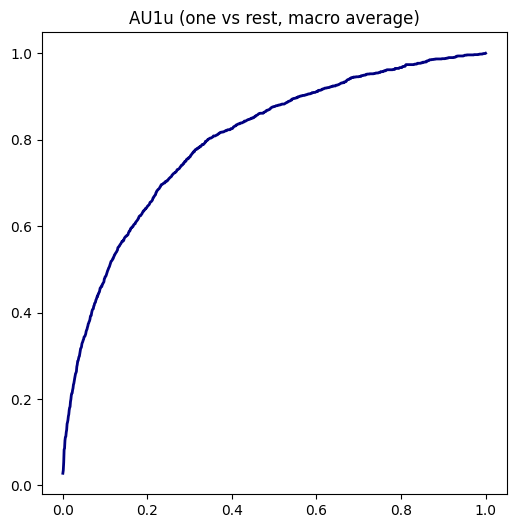

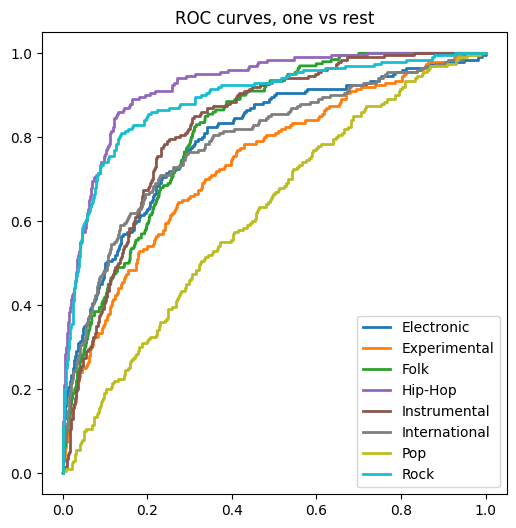

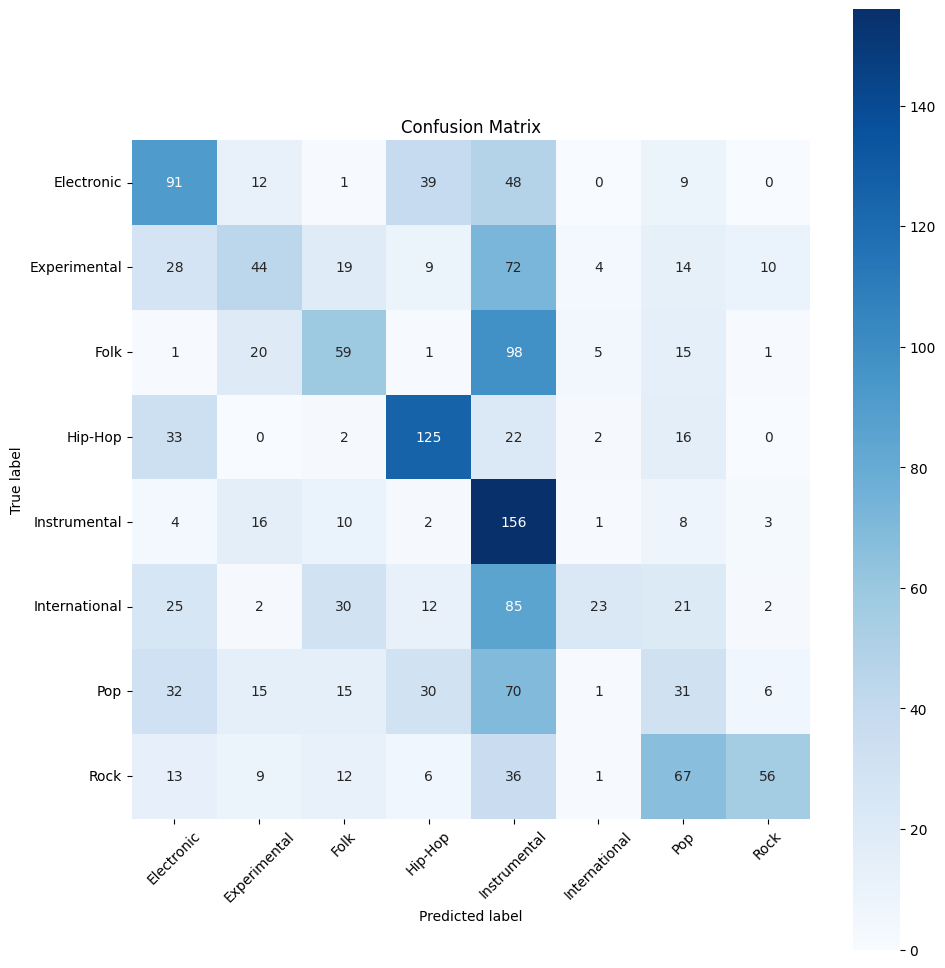

In [47]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['multiclass_unbalanced'] / fma_small_output_dir,
                                 experiment_info=fma_small_multi_exp_info,
                                 epochs=FMA_SMALL_MULTI_TOTAL_EPOCHS,
                                 results=results_fma_small)

In [49]:
metrics_for_correlation_analysis = ["macro_accuracy", "micro_accuracy",
                                    "macro_precision", "micro_precision",
                                    "macro_recall", "micro_recall",
                                    "macro_f1", "micro_f1",
                                    "Kappa",
                                    "MSE",
                                    "LogLoss",
                                    "AUNU", "micro_ROC-AUC",]

In [50]:
selected_metrics = {metric: results_fma_small[metric] for metric in metrics_for_correlation_analysis}
print(selected_metrics)

{'macro_accuracy': tensor(0.8414), 'micro_accuracy': tensor(0.8414), 'macro_precision': tensor(0.4384), 'micro_precision': tensor(0.3656), 'macro_recall': tensor(0.3656), 'micro_recall': tensor(0.3656), 'macro_f1': tensor(0.3485), 'micro_f1': tensor(0.3656), 'Kappa': tensor(0.2750, device='cuda:0'), 'MSE': tensor(0.0961, device='cuda:0'), 'LogLoss': tensor(1.7094, device='cuda:0'), 'AUNU': tensor(0.8005, device='cuda:0', dtype=torch.float64), 'micro_ROC-AUC': tensor(0.7856, device='cuda:0', dtype=torch.float64)}


In [54]:
import pandas as pd

# Convert selected_metrics values to CPU and numpy for correlation calculation
metrics_values = {k: float(v.cpu().detach().numpy()) if hasattr(v, 'cpu') else float(v) for k, v in selected_metrics.items()}

# Create DataFrame
metrics_df = pd.DataFrame([metrics_values])

In [55]:
print(metrics_df)

   macro_accuracy  micro_accuracy  macro_precision  micro_precision  \
0        0.841406        0.841406         0.438381         0.365625   

   macro_recall  micro_recall  macro_f1  micro_f1  Kappa       MSE  LogLoss  \
0      0.365625      0.365625  0.348476  0.365625  0.275  0.096102  1.70939   

       AUNU  micro_ROC-AUC  
0  0.800501        0.78562  


In [56]:
# Calculate Pearson correlation matrix
correlation_matrix = metrics_df.corr(method='pearson')
print(correlation_matrix)

                 macro_accuracy  micro_accuracy  macro_precision  \
macro_accuracy              NaN             NaN              NaN   
micro_accuracy              NaN             NaN              NaN   
macro_precision             NaN             NaN              NaN   
micro_precision             NaN             NaN              NaN   
macro_recall                NaN             NaN              NaN   
micro_recall                NaN             NaN              NaN   
macro_f1                    NaN             NaN              NaN   
micro_f1                    NaN             NaN              NaN   
Kappa                       NaN             NaN              NaN   
MSE                         NaN             NaN              NaN   
LogLoss                     NaN             NaN              NaN   
AUNU                        NaN             NaN              NaN   
micro_ROC-AUC               NaN             NaN              NaN   

                 micro_precision  macro_recall 

# Create and train FMA-medium model

In [ ]:
fma_medium_multi_model_name = "model6"
fma_medium_multi_test_set = "test"

In [ ]:
fma_medium_multi_exp_info = experiment_info(fma_medium_multi_model_name,
                                            "fma_medium",
                                            "multiclass",
                                            fma_medium_multi_test_set,
                                            1,
                                            fma_medium_top_classes)

In [99]:
FMA_MEDIUM_MULTI_EPOCHS = 5
FMA_MEDIUM_MULTI_TOTAL_EPOCHS = 0

In [94]:
model_fma_medium = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_medium_top_classes)).to(device)

In [95]:
fma_medium_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_medium_top_classes), device=device)
fma_medium_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_medium_top_classes), device=device)

In [ ]:
training_loop(model=model_fma_medium,
              epochs=FMA_MEDIUM_MULTI_EPOCHS,
              basic_metrics=fma_medium_basic_multiclass_metrics,
              class_names=fma_medium_top_classes,
              train_dl=fma_medium_train_dl,
              val_dl=fma_medium_val_dl,
              full_metrics=fma_medium_full_multiclass_metrics)

FMA_MEDIUM_MULTI_TOTAL_EPOCHS += FMA_MEDIUM_MULTI_EPOCHS

In [ ]:
results_fma_medium = test_loop(model_fma_medium, fma_medium_full_multiclass_metrics, fma_medium_top_classes, fma_medium_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_medium_multi'],
                                 experiment_info=fma_medium_multi_exp_info,
                                 epochs=FMA_MEDIUM_MULTI_TOTAL_EPOCHS,
                                 results=results_fma_medium)

# Function definition for binary classification

In [11]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# GTZAN binary classification

Best classes: Classical, Pop

In [12]:
gtzan_binary_model_name = "model6"
gtzan_binary_test_set = "test"

In [13]:
GTZAN_CLASS_1 = 'Classical' # Jazz
GTZAN_CLASS_2 = 'Metal'
gtzan_binary_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [14]:
gtzan_binary_exp_info = experiment_info(gtzan_binary_model_name,
                                        "gtzan",
                                        "binary",
                                        gtzan_binary_test_set,
                                        gtzan_binary_classes)

In [15]:
GTZAN_BINARY_EPOCHS = 2
GTZAN_BINARY_TOTAL_EPOCHS = 0

In [16]:
BATCH_SIZE = 32
CHANNELS = 3

In [17]:
gtzan_binary_train_df = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_binary_classes)
gtzan_binary_val_df = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_binary_classes)
gtzan_binary_test_df = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_binary_classes)

In [18]:
gtzan_binary_train_dl = prepare_dataloader_based_on_df(gtzan_binary_train_df, gtzan_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
gtzan_binary_val_dl = prepare_dataloader_based_on_df(gtzan_binary_val_df, gtzan_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
gtzan_binary_test_dl = prepare_dataloader_based_on_df(gtzan_binary_test_df, gtzan_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

In [19]:
model_gtzan_binary = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [20]:
basic_metrics_binary = create_basic_binary_metrics(device=device)
full_metrics_binary = create_full_binary_metrics(device=device)

TRAINING=======
[EPOCH 1], LOSS: 0.18358756445813923
accuracy: 0.9688
f1: 0.9686
VALIDATION=======
accuracy: 0.9500
f1: 0.9524
TRAINING=======
[EPOCH 2], LOSS: 0.020939100690884515
accuracy: 0.9937
f1: 0.9938
VALIDATION=======
accuracy: 0.9500
f1: 0.9524
precision: 0.9091
NPV: 1.0000
recall: 1.0000
specificity: 0.9000
cohen's kappa: 0.9000
MCC: 0.9045
MSE: 0.0340
LogLoss: 0.0894
binary_ROC-AUC: 1.0000


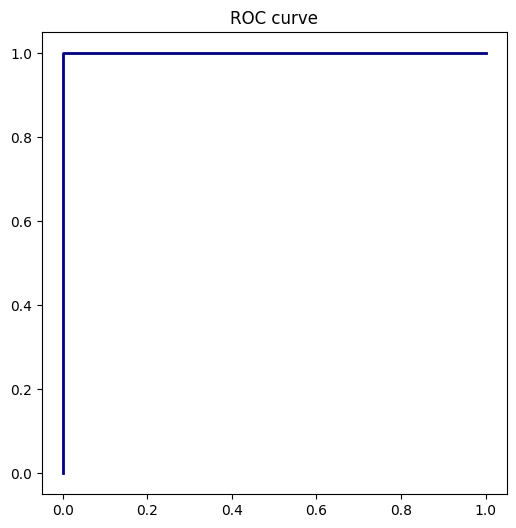

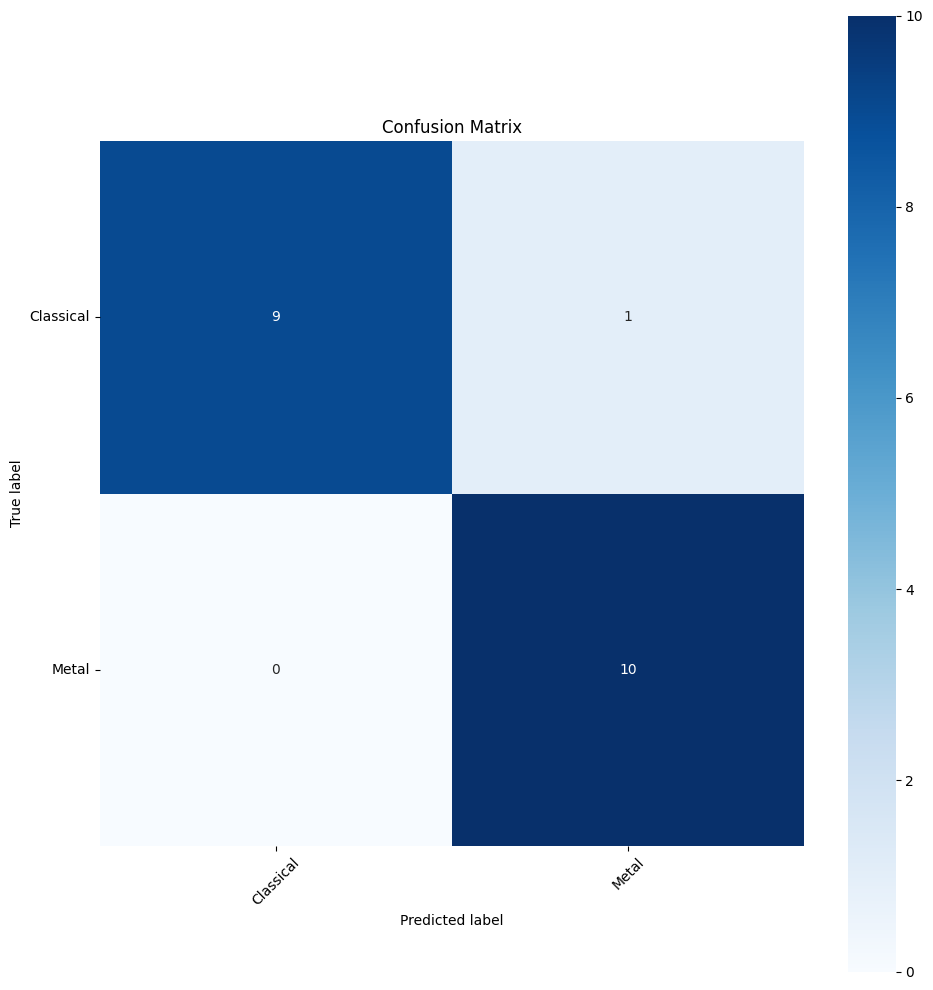

In [27]:
training_loop(model=model_gtzan_binary,
              epochs=GTZAN_BINARY_EPOCHS,
              basic_metrics=basic_metrics_binary,
              class_names=gtzan_binary_classes,
              train_dl=gtzan_binary_train_dl,
              val_dl=gtzan_binary_val_dl,
              full_metrics=full_metrics_binary)

GTZAN_BINARY_TOTAL_EPOCHS += GTZAN_BINARY_EPOCHS

accuracy: 1.0000
f1: 1.0000
precision: 1.0000
NPV: 1.0000
recall: 1.0000
specificity: 1.0000
cohen's kappa: 1.0000
MCC: 1.0000
MSE: 0.0013
LogLoss: 0.0110
binary_ROC-AUC: 1.0000


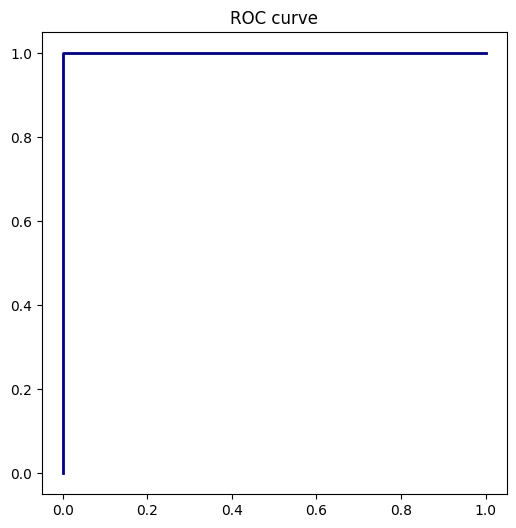

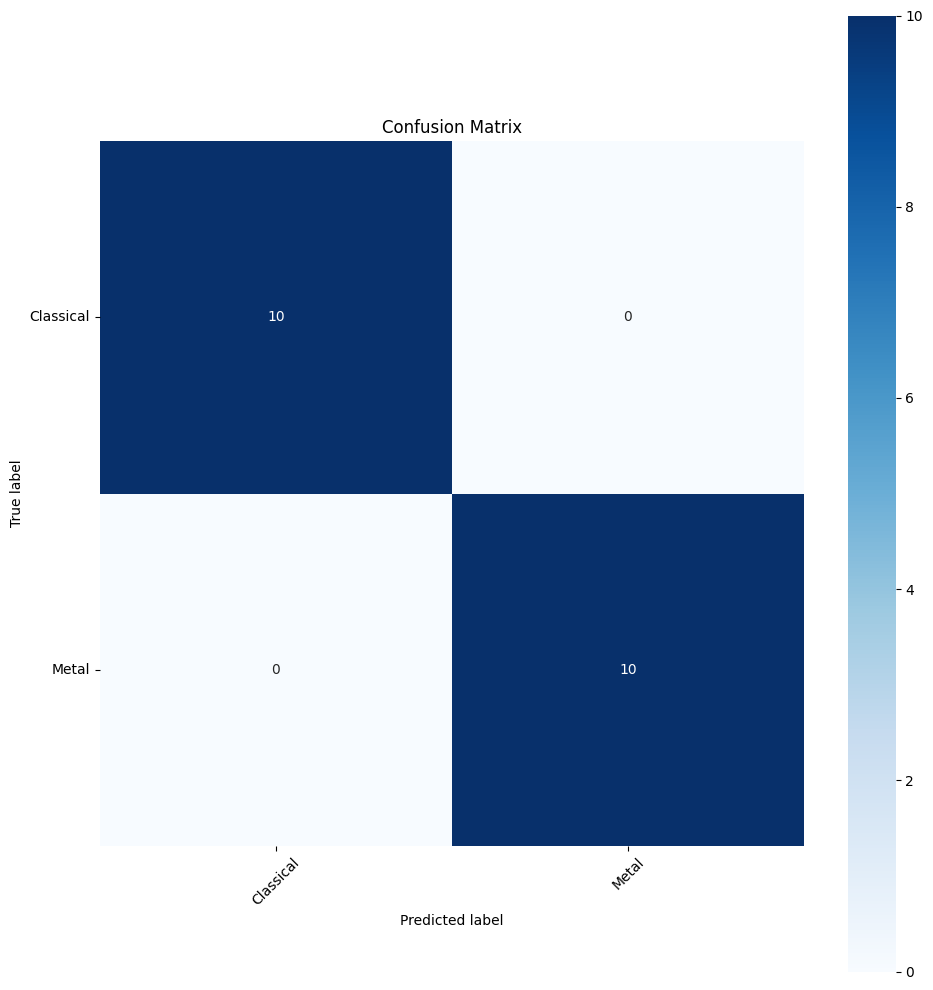

In [28]:
results_gtzan_binary = test_loop(model_gtzan_binary, full_metrics_binary, gtzan_binary_classes, gtzan_binary_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['gtzan_binary'],
                                 experiment_info=gtzan_binary_exp_info,
                                 epochs=GTZAN_BINARY_TOTAL_EPOCHS,
                                 results=results_gtzan_binary)

# FMA-small binary classification

In [ ]:
fma_small_binary_model_name = "model6"
fma_small_binary_test_set = "test"

In [58]:
FMA_SMALL_BINARY_EPOCHS = 5
FMA_SMALL_BINARY_TOTAL_EPOCHS = 0

In [43]:
BATCH_SIZE = 32
CHANNELS = 3

In [44]:
FMA_SMALL_CLASS_1 = 'Electronic' # International
FMA_SMALL_CLASS_2 = 'Hip-Hop'
fma_small_binary_classes = [FMA_SMALL_CLASS_1, FMA_SMALL_CLASS_2]

In [ ]:
fma_small_binary_exp_info = experiment_info(fma_small_binary_model_name,
                                            "fma_small",
                                            "binary",
                                            fma_small_binary_test_set,
                                            fma_small_binary_classes)

In [ ]:
fma_small_binary_train_df = trim_dataframe_to_binary_classification(fma_small_train_df, *fma_small_binary_classes)
fma_small_binary_val_df = trim_dataframe_to_binary_classification(fma_small_val_df,  *fma_small_binary_classes)
fma_small_binary_test_df = trim_dataframe_to_binary_classification(fma_small_test_df,  *fma_small_binary_classes)

In [46]:
fma_small_binary_train_dl = prepare_dataloader_based_on_df(fma_small_binary_train_df, fma_small_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_small_binary_val_dl = prepare_dataloader_based_on_df(fma_small_binary_val_df, fma_small_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_small_binary_test_dl = prepare_dataloader_based_on_df(fma_small_binary_test_df, fma_small_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

In [55]:
model_fma_small_binary = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [48]:
basic_metrics_binary = create_basic_binary_metrics(device=device)
full_metrics_binary = create_full_binary_metrics(device=device)

In [ ]:
training_loop(model=model_fma_small_binary,
              epochs=FMA_SMALL_BINARY_EPOCHS,
              basic_metrics=basic_metrics_binary,
              class_names=fma_small_binary_classes,
              train_dl=fma_small_binary_train_dl,
              val_dl=fma_small_binary_val_dl,
              full_metrics=full_metrics_binary)

FMA_SMALL_BINARY_TOTAL_EPOCHS += FMA_SMALL_BINARY_EPOCHS

In [ ]:
results_fma_small_binary = test_loop(model_fma_small_binary, full_metrics_binary, fma_small_binary_classes, fma_small_binary_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_small_binary'],
                                 experiment_info=fma_small_binary_exp_info,
                                 epochs=FMA_SMALL_BINARY_TOTAL_EPOCHS,
                                 results=results_fma_small_binary)

# FMA-medium binary classification

In [ ]:
fma_medium_binary_model_name = "model6"
fma_medium_binary_test_set = "test"

In [54]:
FMA_MEDIUM_BINARY_EPOCHS = 5
FMA_MEDIUM_BINARY_TOTAL_EPOCHS = 0

In [38]:
BATCH_SIZE = 32
CHANNELS = 3

In [39]:
FMA_MEDIUM_CLASS_1 = 'Electronic'
FMA_MEDIUM_CLASS_2 = 'Rock'
fma_medium_binary_classes = [FMA_MEDIUM_CLASS_1, FMA_MEDIUM_CLASS_2]

In [ ]:
fma_medium_binary_exp_info = experiment_info(fma_medium_binary_model_name,
                                            "fma_medium",
                                            "binary",
                                            fma_medium_binary_test_set,
                                            fma_medium_binary_classes)

In [40]:
fma_medium_binary_train_df = trim_dataframe_to_binary_classification(fma_medium_train_df, *fma_medium_binary_classes)
fma_medium_binary_val_df = trim_dataframe_to_binary_classification(fma_medium_val_df,  *fma_medium_binary_classes)
fma_medium_binary_test_df = trim_dataframe_to_binary_classification(fma_medium_test_df,  *fma_medium_binary_classes)

In [49]:
fma_medium_binary_train_dl = prepare_dataloader_based_on_df(fma_medium_binary_train_df, fma_medium_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_medium_binary_val_dl = prepare_dataloader_based_on_df(fma_medium_binary_val_df, fma_medium_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)
fma_medium_binary_test_dl = prepare_dataloader_based_on_df(fma_medium_binary_test_df, fma_medium_binary_classes, BATCH_SIZE, CHANNELS, IMAGE_SIZE, device)

In [50]:
model_fma_medium_binary = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [51]:
basic_metrics_binary = create_basic_binary_metrics(device=device)
full_metrics_binary = create_full_binary_metrics(device=device)

In [ ]:
training_loop(model=model_fma_medium_binary,
              epochs=FMA_MEDIUM_BINARY_EPOCHS,
              basic_metrics=basic_metrics_binary,
              class_names=fma_medium_binary_classes,
              train_dl=fma_medium_binary_train_dl,
              val_dl=fma_medium_binary_val_dl,
              full_metrics=full_metrics_binary)

FMA_MEDIUM_BINARY_TOTAL_EPOCHS += FMA_MEDIUM_BINARY_EPOCHS

In [ ]:
results_fma_medium_binary = test_loop(model_fma_medium_binary, full_metrics_binary, fma_medium_binary_classes, fma_medium_binary_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_medium_binary'],
                                 experiment_info=fma_medium_binary_exp_info,
                                 epochs=FMA_MEDIUM_BINARY_TOTAL_EPOCHS,
                                 results=results_fma_medium_binary)